In [13]:
# Quick test - Download single ticker to verify connection
print("Testing data download with single ticker (AAPL)...")
test_loader = DataLoader(['AAPL'], '2023-01-01', '2024-01-01', interval='1d')
test_data = test_loader.load_raw_data()
print(f"Test data shape: {test_data.shape}")
print(f"Test data columns: {test_data.columns.tolist()}")
print(f"Test data info:")
print(test_data.info())
print(f"\nFirst few rows:")
print(test_data.head())
print("\n✅ Test successful! Data download is working.")

Testing data download with single ticker (AAPL)...


[*********************100%***********************]  1 of 1 completed

1 Failed download:


1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Test data shape: (0, 7)
Test data columns: [('Date', ''), ('Adj Close', 'AAPL'), ('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL')]
Test data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   (Date, )           0 non-null      datetime64[ns]
 1   (Adj Close, AAPL)  0 non-null      float64       
 2   (Close, AAPL)      0 non-null      float64       
 3   (High, AAPL)       0 non-null      float64       
 4   (Low, AAPL)        0 non-null      float64       
 5   (Open, AAPL)       0 non-null      float64       
 6   (Volume, AAPL)     0 non-null      float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 124.0 bytes
None

First few rows:
Empty DataFrame
Columns: [(Date, ), (Adj Close, AAPL), (Close, AAPL), (High, AAPL), (Low, AAPL), (Open, AAPL), (Volume, AAPL)]
Index: []



# Exploratory Data Analysis Notebook
-   This Notebook is to load raw market data, clean it and explore it and add features to the data for spealist to train on.

## Steps: 
    1.  Download Raw Market 
    2.  Clean the Data
    3.  Add Features to the data
    4.  Visulaze the data
    5.  Save the Cleaned Data and Plots

In [14]:
# Import necessary libraries
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.2.6


In [15]:
# Import custom modules
from src.data.data_loader import DataLoader
from src.data.feature_engineering import FeatureEngineer

print("Custom modules imported successfully!")

Custom modules imported successfully!


## Step 1: Downlaod Raw Data

In [16]:
# Define asset universes for each portfolio
# Date range for historical data
start_date = '2020-01-01'
end_date = '2024-12-31'

# EQUITIES PORTFOLIO - Liquid US stocks across sectors
equities_tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA',  # Tech
    'JPM', 'BAC', 'GS', 'MS', 'C',             # Financials
    'JNJ', 'UNH', 'PFE', 'ABBV', 'TMO',        # Healthcare
    'XOM', 'CVX', 'COP', 'SLB', 'EOG',         # Energy
    'WMT', 'HD', 'MCD', 'NKE', 'COST'          # Consumer
]

# FX PORTFOLIO - Major currency pairs (using FX futures/ETFs as proxy)
fx_tickers = [
    'EURUSD=X',  # EUR/USD
    'GBPUSD=X',  # GBP/USD
    'USDJPY=X',  # USD/JPY
    'AUDUSD=X',  # AUD/USD
    'USDCAD=X',  # USD/CAD
    'USDCHF=X',  # USD/CHF
    'NZDUSD=X',  # NZD/USD
    'EURGBP=X',  # EUR/GBP
    'EURJPY=X',  # EUR/JPY
    'GBPJPY=X'   # GBP/JPY
]

# FUTURES PORTFOLIO - Using ETFs as proxies for futures contracts
futures_tickers = [
    'GC=F',   # Gold Futures
    'SI=F',   # Silver Futures
    'CL=F',   # Crude Oil WTI Futures
    'NG=F',   # Natural Gas Futures
    'ZC=F',   # Corn Futures
    'ZW=F',   # Wheat Futures
    'HG=F',   # Copper Futures
    'ES=F',   # E-mini S&P 500 Futures
    'NQ=F',   # E-mini NASDAQ Futures
    'ZB=F'    # Treasury Bond Futures
]

print(f"Data range: {start_date} to {end_date}")
print(f"\nEquities Portfolio: {len(equities_tickers)} tickers")
print(f"FX Portfolio: {len(fx_tickers)} pairs")
print(f"Futures Portfolio: {len(futures_tickers)} contracts")

Data range: 2020-01-01 to 2024-12-31

Equities Portfolio: 25 tickers
FX Portfolio: 10 pairs
Futures Portfolio: 10 contracts


In [17]:
# Download data for each portfolio with separate ArcticDB databases
print("=" * 80)
print("DOWNLOADING EQUITIES DATA")
print("=" * 80)
equities_loader = DataLoader(equities_tickers, start_date, end_date, interval='1d', 
                             db_url='lmdb://equities_data')
equities_raw = equities_loader.load_raw_data()
print(f"Equities data shape: {equities_raw.shape}")
print(f"Equities columns: {equities_raw.columns.tolist()[:5]}")  # Show first 5 columns
if 'Date' in equities_raw.columns:
    print(f"Equities date range: {equities_raw['Date'].min()} to {equities_raw['Date'].max()}")
else:
    print(f"Equities index range: {equities_raw.index.min()} to {equities_raw.index.max()}")
print(f"Sample data:\n{equities_raw.head(3)}")

# Store in ArcticDB
print("\nStoring equities data in ArcticDB (equities_data database)...")
equities_loader.store_data("raw_market_data", equities_raw)
print("✅ Equities data stored in ArcticDB")

print("\n" + "=" * 80)
print("DOWNLOADING FX DATA")
print("=" * 80)
fx_loader = DataLoader(fx_tickers, start_date, end_date, interval='1d',
                       db_url='lmdb://fx_data')
fx_raw = fx_loader.load_raw_data()
print(f"FX data shape: {fx_raw.shape}")
print(f"FX columns: {fx_raw.columns.tolist()[:5]}")
if 'Date' in fx_raw.columns:
    print(f"FX date range: {fx_raw['Date'].min()} to {fx_raw['Date'].max()}")
else:
    print(f"FX index range: {fx_raw.index.min()} to {fx_raw.index.max()}")
print(f"Sample data:\n{fx_raw.head(3)}")

# Store in ArcticDB
print("\nStoring FX data in ArcticDB (fx_data database)...")
fx_loader.store_data("raw_market_data", fx_raw)
print("✅ FX data stored in ArcticDB")

print("\n" + "=" * 80)
print("DOWNLOADING FUTURES DATA")
print("=" * 80)
futures_loader = DataLoader(futures_tickers, start_date, end_date, interval='1d',
                            db_url='lmdb://futures_data')
futures_raw = futures_loader.load_raw_data()
print(f"Futures data shape: {futures_raw.shape}")
print(f"Futures columns: {futures_raw.columns.tolist()[:5]}")
if 'Date' in futures_raw.columns:
    print(f"Futures date range: {futures_raw['Date'].min()} to {futures_raw['Date'].max()}")
else:
    print(f"Futures index range: {futures_raw.index.min()} to {futures_raw.index.max()}")
print(f"Sample data:\n{futures_raw.head(3)}")

# Store in ArcticDB
print("\nStoring futures data in ArcticDB (futures_data database)...")
futures_loader.store_data("raw_market_data", futures_raw)
print("✅ Futures data stored in ArcticDB")

print("\n✅ All data downloaded and stored in separate ArcticDB databases!")
print("\n📁 ArcticDB Databases Created:")
print("   - lmdb://equities_data")
print("   - lmdb://fx_data")
print("   - lmdb://futures_data")

DOWNLOADING EQUITIES DATA


[*********************100%***********************]  25 of 25 completed

25 Failed downloads:
['TMO', 'NKE', 'COP', 'MCD', 'AAPL', 'SLB', 'BAC', 'HD', 'WMT', 'PFE', 'NVDA', 'GOOGL', 'JPM', 'COST', 'MS', 'ABBV', 'C', 'GS', 'UNH', 'JNJ', 'EOG', 'XOM', 'CVX', 'AMZN', 'MSFT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


25 Failed downloads:
['TMO', 'NKE', 'COP', 'MCD', 'AAPL', 'SLB', 'BAC', 'HD', 'WMT', 'PFE', 'NVDA', 'GOOGL', 'JPM', 'COST', 'MS', 'ABBV', 'C', 'GS', 'UNH', 'JNJ', 'EOG', 'XOM', 'CVX', 'AMZN', 'MSFT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Equities data shape: (0, 151)
Equities columns: [('Date', ''), ('Adj Close', 'AAPL'), ('Adj Close', 'ABBV'), ('Adj Close', 'AMZN'), ('Adj Close', 'BAC')]
Equities date range: NaT to NaT
Sample data:
Empty DataFrame
Columns: [(Date, ), (Adj Close, AAPL), (Adj Close, ABBV), (Adj Close, AMZN), (Adj Close, BAC), (Adj Close, C), (Adj Close, COP), (Adj Close, COST), (Adj Close, CVX), (Adj Close, EOG), (Adj Close, GOOGL), (Adj Close, GS), (Adj Close, HD), (Adj Close, JNJ), (Adj Close, JPM), (Adj Close, MCD), (Adj Close, MS), (Adj Close, MSFT), (Adj Close, NKE), (Adj Close, NVDA), (Adj Close, PFE), (Adj Close, SLB), (Adj Close, TMO), (Adj Close, UNH), (Adj Close, WMT), (Adj Close, XOM), (Close, AAPL), (Close, ABBV), (Close, AMZN), (Close, BAC), (Close, C), (Close, COP), (Close, COST), (Close, CVX), (Close, EOG), (Close, GOOGL), (Close, GS), (Close, HD), (Close, JNJ), (Close, JPM), (Close, MCD), (Close, MS), (Close, MSFT), (Close, NKE), (Close, NVDA), (Close, PFE), (Close, SLB), (Close, TMO), (

[*********************100%***********************]  10 of 10 completed

10 Failed downloads:


10 Failed downloads:
['GBPUSD=X', 'AUDUSD=X', 'EURJPY=X', 'NZDUSD=X', 'GBPJPY=X', 'EURUSD=X', 'USDCHF=X', 'USDJPY=X', 'EURGBP=X', 'USDCAD=X']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
['GBPUSD=X', 'AUDUSD=X', 'EURJPY=X', 'NZDUSD=X', 'GBPJPY=X', 'EURUSD=X', 'USDCHF=X', 'USDJPY=X', 'EURGBP=X', 'USDCAD=X']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


FX data shape: (0, 61)
FX columns: [('Date', ''), ('Adj Close', 'AUDUSD=X'), ('Adj Close', 'EURGBP=X'), ('Adj Close', 'EURJPY=X'), ('Adj Close', 'EURUSD=X')]
FX date range: NaT to NaT
Sample data:
Empty DataFrame
Columns: [(Date, ), (Adj Close, AUDUSD=X), (Adj Close, EURGBP=X), (Adj Close, EURJPY=X), (Adj Close, EURUSD=X), (Adj Close, GBPJPY=X), (Adj Close, GBPUSD=X), (Adj Close, NZDUSD=X), (Adj Close, USDCAD=X), (Adj Close, USDCHF=X), (Adj Close, USDJPY=X), (Close, AUDUSD=X), (Close, EURGBP=X), (Close, EURJPY=X), (Close, EURUSD=X), (Close, GBPJPY=X), (Close, GBPUSD=X), (Close, NZDUSD=X), (Close, USDCAD=X), (Close, USDCHF=X), (Close, USDJPY=X), (High, AUDUSD=X), (High, EURGBP=X), (High, EURJPY=X), (High, EURUSD=X), (High, GBPJPY=X), (High, GBPUSD=X), (High, NZDUSD=X), (High, USDCAD=X), (High, USDCHF=X), (High, USDJPY=X), (Low, AUDUSD=X), (Low, EURGBP=X), (Low, EURJPY=X), (Low, EURUSD=X), (Low, GBPJPY=X), (Low, GBPUSD=X), (Low, NZDUSD=X), (Low, USDCAD=X), (Low, USDCHF=X), (Low, USDJPY=X

[*********************100%***********************]  10 of 10 completed

10 Failed downloads:
['GC=F', 'ES=F', 'ZW=F', 'ZB=F', 'NQ=F', 'NG=F', 'ZC=F', 'CL=F', 'SI=F', 'HG=F']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')
[*********************100%***********************]  10 of 10 completed

10 Failed downloads:
['GC=F', 'ES=F', 'ZW=F', 'ZB=F', 'NQ=F', 'NG=F', 'ZC=F', 'CL=F', 'SI=F', 'HG=F']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Futures data shape: (0, 61)
Futures columns: [('Date', ''), ('Adj Close', 'CL=F'), ('Adj Close', 'ES=F'), ('Adj Close', 'GC=F'), ('Adj Close', 'HG=F')]
Futures date range: NaT to NaT
Sample data:
Empty DataFrame
Columns: [(Date, ), (Adj Close, CL=F), (Adj Close, ES=F), (Adj Close, GC=F), (Adj Close, HG=F), (Adj Close, NG=F), (Adj Close, NQ=F), (Adj Close, SI=F), (Adj Close, ZB=F), (Adj Close, ZC=F), (Adj Close, ZW=F), (Close, CL=F), (Close, ES=F), (Close, GC=F), (Close, HG=F), (Close, NG=F), (Close, NQ=F), (Close, SI=F), (Close, ZB=F), (Close, ZC=F), (Close, ZW=F), (High, CL=F), (High, ES=F), (High, GC=F), (High, HG=F), (High, NG=F), (High, NQ=F), (High, SI=F), (High, ZB=F), (High, ZC=F), (High, ZW=F), (Low, CL=F), (Low, ES=F), (Low, GC=F), (Low, HG=F), (Low, NG=F), (Low, NQ=F), (Low, SI=F), (Low, ZB=F), (Low, ZC=F), (Low, ZW=F), (Open, CL=F), (Open, ES=F), (Open, GC=F), (Open, HG=F), (Open, NG=F), (Open, NQ=F), (Open, SI=F), (Open, ZB=F), (Open, ZC=F), (Open, ZW=F), (Volume, CL=F), (V

## Step 2: Clean the Data

In [18]:
# Data cleaning and quality checks
def clean_and_analyze_data(df, portfolio_name):
    """Clean data and provide quality metrics."""
    print(f"\n{'=' * 80}")
    print(f"{portfolio_name.upper()} - DATA QUALITY ANALYSIS")
    print(f"{'=' * 80}")
    
    df_clean = df.copy()
    
    # Set Date as index
    if 'Date' in df_clean.columns:
        df_clean.set_index('Date', inplace=True)
    
    # Check for missing values
    print(f"\n📊 Missing Values:")
    missing = df_clean.isnull().sum()
    missing_pct = (missing / len(df_clean)) * 100
    missing_df = pd.DataFrame({
        'Missing Count': missing[missing > 0],
        'Percentage': missing_pct[missing > 0]
    })
    if len(missing_df) > 0:
        print(missing_df.head(10))
    else:
        print("No missing values found!")
    
    # Handle missing values
    df_clean.ffill(inplace=True)
    df_clean.bfill(inplace=True)
    
    # Check for duplicates
    duplicates = df_clean.index.duplicated().sum()
    print(f"\n📊 Duplicate rows: {duplicates}")
    if duplicates > 0:
        df_clean = df_clean[~df_clean.index.duplicated(keep='first')]
    
    # Data statistics
    print(f"\n📊 Data Summary:")
    print(f"Total rows: {len(df_clean):,}")
    print(f"Total columns: {len(df_clean.columns):,}")
    print(f"Memory usage: {df_clean.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    return df_clean

# Clean all portfolios
equities_clean = clean_and_analyze_data(equities_raw, "Equities")
fx_clean = clean_and_analyze_data(fx_raw, "FX")
futures_clean = clean_and_analyze_data(futures_raw, "Futures")

print("\n✅ All data cleaned successfully!")


EQUITIES - DATA QUALITY ANALYSIS

📊 Missing Values:
No missing values found!

📊 Duplicate rows: 0

📊 Data Summary:
Total rows: 0
Total columns: 150
Memory usage: 0.00 MB

FX - DATA QUALITY ANALYSIS

📊 Missing Values:
No missing values found!

📊 Duplicate rows: 0

📊 Data Summary:
Total rows: 0
Total columns: 60
Memory usage: 0.00 MB

FUTURES - DATA QUALITY ANALYSIS

📊 Missing Values:
No missing values found!

📊 Duplicate rows: 0

📊 Data Summary:
Total rows: 0
Total columns: 60
Memory usage: 0.00 MB

✅ All data cleaned successfully!


In [19]:
# Display sample data for each portfolio
print("EQUITIES PORTFOLIO - Sample Data:")
print(equities_clean.head())
print(f"\nColumns: {list(equities_clean.columns)}")

print("\n" + "=" * 80)
print("FX PORTFOLIO - Sample Data:")
print(fx_clean.head())

print("\n" + "=" * 80)
print("FUTURES PORTFOLIO - Sample Data:")
print(futures_clean.head())

EQUITIES PORTFOLIO - Sample Data:
Empty DataFrame
Columns: [(Adj Close, AAPL), (Adj Close, ABBV), (Adj Close, AMZN), (Adj Close, BAC), (Adj Close, C), (Adj Close, COP), (Adj Close, COST), (Adj Close, CVX), (Adj Close, EOG), (Adj Close, GOOGL), (Adj Close, GS), (Adj Close, HD), (Adj Close, JNJ), (Adj Close, JPM), (Adj Close, MCD), (Adj Close, MS), (Adj Close, MSFT), (Adj Close, NKE), (Adj Close, NVDA), (Adj Close, PFE), (Adj Close, SLB), (Adj Close, TMO), (Adj Close, UNH), (Adj Close, WMT), (Adj Close, XOM), (Close, AAPL), (Close, ABBV), (Close, AMZN), (Close, BAC), (Close, C), (Close, COP), (Close, COST), (Close, CVX), (Close, EOG), (Close, GOOGL), (Close, GS), (Close, HD), (Close, JNJ), (Close, JPM), (Close, MCD), (Close, MS), (Close, MSFT), (Close, NKE), (Close, NVDA), (Close, PFE), (Close, SLB), (Close, TMO), (Close, UNH), (Close, WMT), (Close, XOM), (High, AAPL), (High, ABBV), (High, AMZN), (High, BAC), (High, C), (High, COP), (High, COST), (High, CVX), (High, EOG), (High, GOOGL), 

## Step 3: Add Features 

In [20]:
# Feature Engineering for each asset
# Note: We'll process one ticker at a time due to MultiIndex structure

def engineer_features_for_portfolio(df_raw, tickers, portfolio_name):
    """Engineer features for each ticker in the portfolio."""
    print(f"\n{'=' * 80}")
    print(f"ENGINEERING FEATURES FOR {portfolio_name.upper()}")
    print(f"{'=' * 80}")
    
    all_features = {}
    
    for ticker in tickers:
        try:
            print(f"\nProcessing {ticker}...")
            
            # Extract single ticker data
            ticker_df = pd.DataFrame()
            ticker_df['Date'] = df_raw.index if isinstance(df_raw.index, pd.DatetimeIndex) else df_raw.index
            
            # Handle MultiIndex columns from yfinance
            if isinstance(df_raw.columns, pd.MultiIndex):
                for col in ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']:
                    if (col, ticker) in df_raw.columns:
                        ticker_df[col] = df_raw[(col, ticker)]
                    elif col in df_raw.columns:
                        ticker_df[col] = df_raw[col]
            else:
                # Single ticker or flattened structure
                close_cols = [c for c in df_raw.columns if 'Close' in str(c) and ticker in str(c)]
                if close_cols:
                    ticker_df['Close'] = df_raw[close_cols[0]]
                elif 'Close' in df_raw.columns:
                    ticker_df['Close'] = df_raw['Close']
            
            if 'Close' not in ticker_df.columns or ticker_df['Close'].isnull().all():
                print(f"  ⚠️  Skipping {ticker} - no valid Close data")
                continue
            
            # Set Date as index
            if 'Date' in ticker_df.columns:
                ticker_df.set_index('Date', inplace=True)
            
            # Engineer features
            engineer = FeatureEngineer(ticker_df, price_col='Close')
            ticker_features = engineer.add_all_features(
                include_volume='Volume' in ticker_df.columns,
                include_microstructure=True,
                include_regime=True
            )
            
            all_features[ticker] = ticker_features
            print(f"  ✅ {ticker}: {len(ticker_features.columns)} features created")
            
        except Exception as e:
            print(f"  ❌ Error processing {ticker}: {str(e)}")
            continue
    
    print(f"\n✅ Feature engineering complete for {portfolio_name}")
    print(f"Successfully processed {len(all_features)}/{len(tickers)} tickers")
    
    return all_features

# This will take a few minutes...
print("Starting feature engineering (this may take a few minutes)...")
equities_features = engineer_features_for_portfolio(equities_clean, equities_tickers, "Equities")
fx_features = engineer_features_for_portfolio(fx_clean, fx_tickers, "FX")
futures_features = engineer_features_for_portfolio(futures_clean, futures_tickers, "Futures")

Starting feature engineering (this may take a few minutes)...

ENGINEERING FEATURES FOR EQUITIES

Processing AAPL...
  ⚠️  Skipping AAPL - no valid Close data

Processing MSFT...
  ⚠️  Skipping MSFT - no valid Close data

Processing GOOGL...
  ⚠️  Skipping GOOGL - no valid Close data

Processing AMZN...
  ⚠️  Skipping AMZN - no valid Close data

Processing NVDA...
  ⚠️  Skipping NVDA - no valid Close data

Processing JPM...
  ⚠️  Skipping JPM - no valid Close data

Processing BAC...
  ⚠️  Skipping BAC - no valid Close data

Processing GS...
  ⚠️  Skipping GS - no valid Close data

Processing MS...
  ⚠️  Skipping MS - no valid Close data

Processing C...
  ⚠️  Skipping C - no valid Close data

Processing JNJ...
  ⚠️  Skipping JNJ - no valid Close data

Processing UNH...
  ⚠️  Skipping UNH - no valid Close data

Processing PFE...
  ⚠️  Skipping PFE - no valid Close data  ⚠️  Skipping PFE - no valid Close data

Processing ABBV...
  ⚠️  Skipping ABBV - no valid Close data

Processing TMO..

In [21]:
# Display feature summary for sample tickers
print("SAMPLE FEATURE SUMMARY")
print("=" * 80)

if equities_features:
    sample_ticker = list(equities_features.keys())[0]
    print(f"\n{sample_ticker} (Equities) - Feature Columns:")
    print(equities_features[sample_ticker].columns.tolist()[:20], "... (showing first 20)")
    print(f"\nTotal features: {len(equities_features[sample_ticker].columns)}")
    print(f"\nSample data:")
    print(equities_features[sample_ticker].tail(3))

if fx_features:
    sample_fx = list(fx_features.keys())[0]
    print(f"\n\n{sample_fx} (FX) - Total features: {len(fx_features[sample_fx].columns)}")

if futures_features:
    sample_fut = list(futures_features.keys())[0]
    print(f"{sample_fut} (Futures) - Total features: {len(futures_features[sample_fut].columns)}")

SAMPLE FEATURE SUMMARY


## Step 4: Visualia Data with Plots

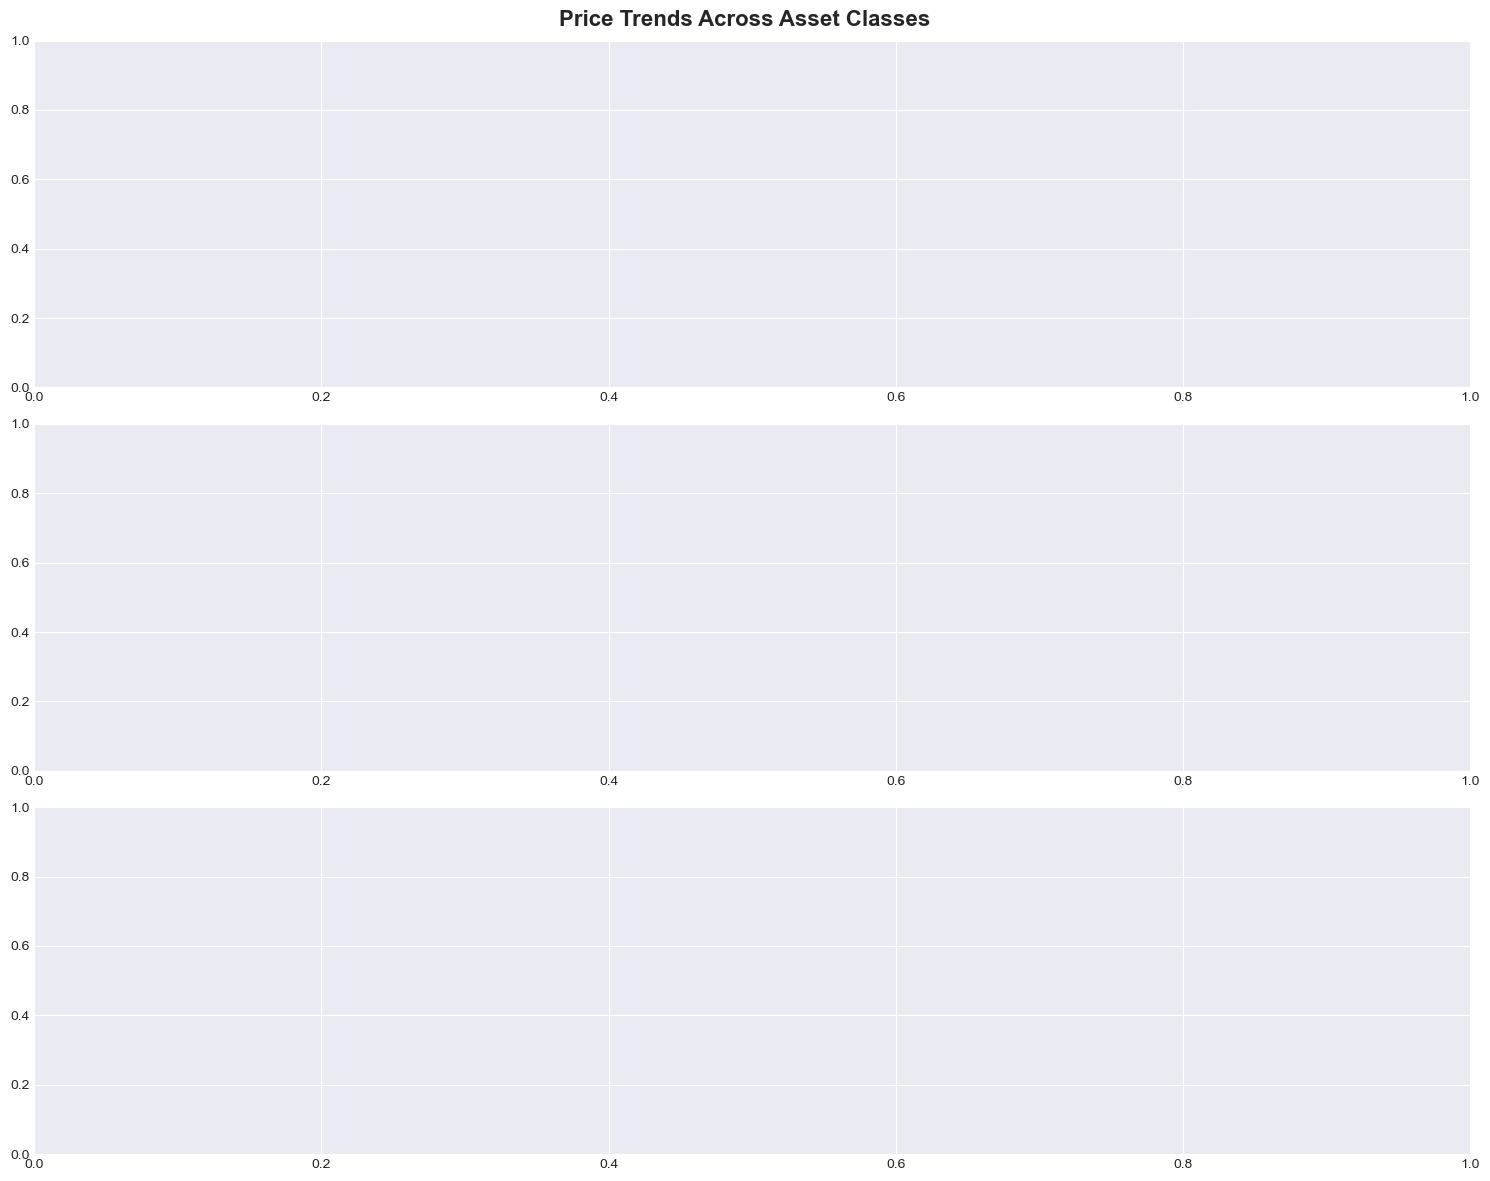

✅ Price trends plot saved to reports/figures/price_trends.png


In [22]:
# Visualization 1: Price trends for sample assets
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('Price Trends Across Asset Classes', fontsize=16, fontweight='bold')

# Equities
if equities_features:
    sample_equities = list(equities_features.keys())[:3]
    for ticker in sample_equities:
        axes[0].plot(equities_features[ticker].index, 
                    equities_features[ticker]['Close'], 
                    label=ticker, linewidth=2)
    axes[0].set_title('Equities Portfolio - Price Trends', fontsize=14)
    axes[0].set_ylabel('Price ($)', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

# FX
if fx_features:
    sample_fx = list(fx_features.keys())[:3]
    for ticker in sample_fx:
        axes[1].plot(fx_features[ticker].index, 
                    fx_features[ticker]['Close'], 
                    label=ticker, linewidth=2)
    axes[1].set_title('FX Portfolio - Exchange Rate Trends', fontsize=14)
    axes[1].set_ylabel('Exchange Rate', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

# Futures
if futures_features:
    sample_futures = list(futures_features.keys())[:3]
    for ticker in sample_futures:
        axes[2].plot(futures_features[ticker].index, 
                    futures_features[ticker]['Close'], 
                    label=ticker, linewidth=2)
    axes[2].set_title('Futures Portfolio - Price Trends', fontsize=14)
    axes[2].set_ylabel('Price', fontsize=12)
    axes[2].set_xlabel('Date', fontsize=12)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/price_trends.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Price trends plot saved to reports/figures/price_trends.png")

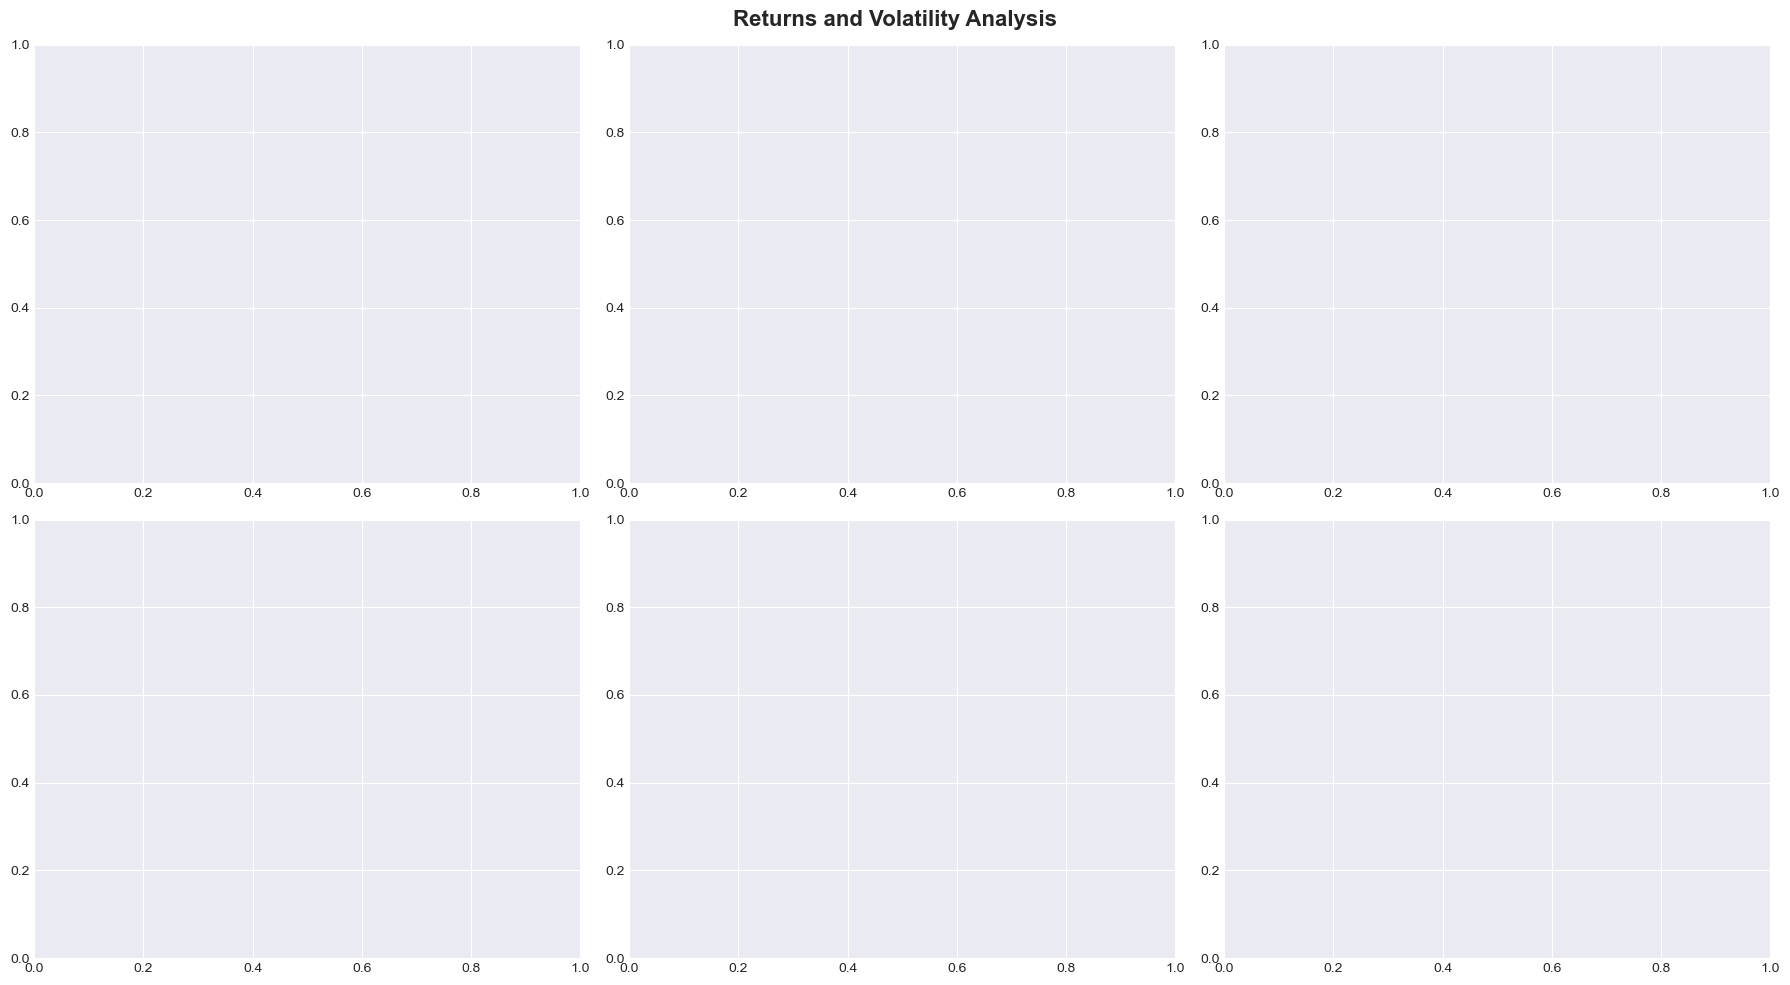

✅ Returns and volatility analysis saved to reports/figures/returns_volatility_analysis.png


In [23]:
# Visualization 2: Returns and Volatility Analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Returns and Volatility Analysis', fontsize=16, fontweight='bold')

def plot_returns_analysis(features_dict, ax_return, ax_vol, title):
    """Plot returns distribution and volatility for a portfolio."""
    all_returns = []
    all_vols = []
    tickers = []
    
    for ticker, df in features_dict.items():
        if 'return_1d' in df.columns and 'volatility_20d' in df.columns:
            returns = df['return_1d'].dropna()
            vol = df['volatility_20d'].dropna()
            
            all_returns.extend(returns.values)
            if len(vol) > 0:
                all_vols.append(vol.iloc[-1])
                tickers.append(ticker)
    
    # Returns distribution
    if all_returns:
        ax_return.hist(all_returns, bins=50, alpha=0.7, edgecolor='black')
        ax_return.axvline(x=0, color='red', linestyle='--', linewidth=2)
        ax_return.set_title(f'{title} - Daily Returns Distribution', fontsize=12)
        ax_return.set_xlabel('Daily Returns')
        ax_return.set_ylabel('Frequency')
        ax_return.grid(True, alpha=0.3)
    
    # Volatility comparison
    if all_vols and tickers:
        colors = plt.cm.viridis(np.linspace(0, 1, len(tickers)))
        ax_vol.bar(range(len(tickers)), all_vols, color=colors)
        ax_vol.set_title(f'{title} - Annualized Volatility', fontsize=12)
        ax_vol.set_xlabel('Assets')
        ax_vol.set_ylabel('Volatility')
        ax_vol.set_xticks(range(len(tickers)))
        ax_vol.set_xticklabels(tickers, rotation=45, ha='right')
        ax_vol.grid(True, alpha=0.3, axis='y')

# Plot for each portfolio
plot_returns_analysis(equities_features, axes[0, 0], axes[1, 0], 'Equities')
plot_returns_analysis(fx_features, axes[0, 1], axes[1, 1], 'FX')
plot_returns_analysis(futures_features, axes[0, 2], axes[1, 2], 'Futures')

plt.tight_layout()
plt.savefig('../reports/figures/returns_volatility_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Returns and volatility analysis saved to reports/figures/returns_volatility_analysis.png")

# Step 5: Store Cleaned Data for Speaicalist ML Training and Plots for Understanding

In [24]:
# Save processed data with features to disk AND ArcticDB
import os

# Create directories if they don't exist
os.makedirs('../data/processed/equities', exist_ok=True)
os.makedirs('../data/processed/fx', exist_ok=True)
os.makedirs('../data/processed/futures', exist_ok=True)
os.makedirs('../reports/figures', exist_ok=True)

def save_portfolio_features(features_dict, portfolio_name, loader):
    """Save features for each ticker in a portfolio to CSV and ArcticDB."""
    print(f"\n{'=' * 80}")
    print(f"SAVING {portfolio_name.upper()} PORTFOLIO DATA")
    print(f"{'=' * 80}")
    
    saved_count = 0
    for ticker, df in features_dict.items():
        try:
            # Clean ticker name for filename
            clean_ticker = ticker.replace('=', '_').replace('/', '_')
            
            # Save to CSV
            filepath = f'../data/processed/{portfolio_name.lower()}/{clean_ticker}_features.csv'
            df.to_csv(filepath)
            print(f"✅ CSV: {ticker} -> {filepath}")
            
            # Save to ArcticDB
            library_name = f"{portfolio_name.lower()}_features"
            loader.arctic_database.get_library(library_name, create_if_missing=True).write(
                clean_ticker, df
            )
            print(f"   📊 ArcticDB: {ticker} -> {library_name}/{clean_ticker}")
            
            saved_count += 1
        except Exception as e:
            print(f"❌ Error saving {ticker}: {str(e)}")
    
    print(f"\n📊 Saved {saved_count}/{len(features_dict)} tickers for {portfolio_name}")
    return saved_count

# Save all portfolios to both CSV and ArcticDB
total_saved = 0
total_saved += save_portfolio_features(equities_features, 'equities', equities_loader)
total_saved += save_portfolio_features(fx_features, 'fx', fx_loader)
total_saved += save_portfolio_features(futures_features, 'futures', futures_loader)

print(f"\n{'=' * 80}")
print(f"TOTAL ASSETS SAVED: {total_saved}")
print(f"{'=' * 80}")
print("\n📁 Data saved to:")
print("   CSV Files: data/processed/[equities|fx|futures]/")
print("\n📊 ArcticDB Libraries Created:")
print("   - equities_data/equities_features")
print("   - fx_data/fx_features")
print("   - futures_data/futures_features")


SAVING EQUITIES PORTFOLIO DATA

📊 Saved 0/0 tickers for equities

SAVING FX PORTFOLIO DATA

📊 Saved 0/0 tickers for fx

SAVING FUTURES PORTFOLIO DATA

📊 Saved 0/0 tickers for futures

TOTAL ASSETS SAVED: 0

📁 Data saved to:
   CSV Files: data/processed/[equities|fx|futures]/

📊 ArcticDB Libraries Created:
   - equities_data/equities_features
   - fx_data/fx_features
   - futures_data/futures_features


In [25]:
# Generate comprehensive summary report
print("=" * 80)
print("DATA LOADING AND EDA SUMMARY REPORT")
print("=" * 80)

summary = {
    'Portfolio': ['Equities', 'FX', 'Futures', 'TOTAL'],
    'Tickers Requested': [len(equities_tickers), len(fx_tickers), len(futures_tickers), 
                          len(equities_tickers) + len(fx_tickers) + len(futures_tickers)],
    'Successfully Processed': [len(equities_features), len(fx_features), len(futures_features),
                               len(equities_features) + len(fx_features) + len(futures_features)],
    'Features per Asset': [
        len(equities_features[list(equities_features.keys())[0]].columns) if equities_features else 0,
        len(fx_features[list(fx_features.keys())[0]].columns) if fx_features else 0,
        len(futures_features[list(futures_features.keys())[0]].columns) if futures_features else 0,
        'Varies'
    ]
}

summary_df = pd.DataFrame(summary)
print("\n", summary_df.to_string(index=False))

print("\n" + "=" * 80)
print("SAVED FILES:")
print("=" * 80)
print(f"📁 Equities data: data/processed/equities/")
print(f"📁 FX data: data/processed/fx/")
print(f"📁 Futures data: data/processed/futures/")
print(f"📊 Plots: reports/figures/")

print("\n" + "=" * 80)
print("NEXT STEPS:")
print("=" * 80)
print("1. ✅ Data loaded and cleaned")
print("2. ✅ Features engineered")
print("3. ✅ EDA visualizations created")
print("4. ✅ Data saved for specialist training")
print("5. ⏭️  Proceed to specialist environment testing (notebook 01)")
print("6. ⏭️  Train specialist agents (notebook 02)")
print("=" * 80)

print("\n🎉 Notebook 00 Complete!")

DATA LOADING AND EDA SUMMARY REPORT

 Portfolio  Tickers Requested  Successfully Processed Features per Asset
 Equities                 25                       0                  0
       FX                 10                       0                  0
  Futures                 10                       0                  0
    TOTAL                 45                       0             Varies

SAVED FILES:
📁 Equities data: data/processed/equities/
📁 FX data: data/processed/fx/
📁 Futures data: data/processed/futures/
📊 Plots: reports/figures/

NEXT STEPS:
1. ✅ Data loaded and cleaned
2. ✅ Features engineered
3. ✅ EDA visualizations created
4. ✅ Data saved for specialist training
5. ⏭️  Proceed to specialist environment testing (notebook 01)
6. ⏭️  Train specialist agents (notebook 02)

🎉 Notebook 00 Complete!


## Bonus: Verify ArcticDB Storage

In [26]:
# Verify ArcticDB storage - list all libraries and symbols
import arcticdb as adb

print("=" * 80)
print("ARCTICDB STORAGE VERIFICATION")
print("=" * 80)

portfolios = [
    ('equities_data', equities_loader),
    ('fx_data', fx_loader),
    ('futures_data', futures_loader)
]

for db_name, loader in portfolios:
    print(f"\n📊 Database: {db_name}")
    print("-" * 80)
    
    # List all libraries in this database
    try:
        libraries = loader.arctic_database.list_libraries()
        print(f"Libraries: {libraries}")
        
        for lib_name in libraries:
            lib = loader.arctic_database.get_library(lib_name)
            symbols = lib.list_symbols()
            print(f"\n  Library '{lib_name}': {len(symbols)} symbols")
            if symbols:
                print(f"    Sample symbols: {symbols[:5]}")
                
                # Show info for first symbol
                if symbols:
                    sample_data = lib.read(symbols[0]).data
                    print(f"    Sample data shape for '{symbols[0]}': {sample_data.shape}")
    except Exception as e:
        print(f"  Error: {str(e)}")

print("\n" + "=" * 80)
print("✅ ArcticDB verification complete!")
print("=" * 80)

ARCTICDB STORAGE VERIFICATION

📊 Database: equities_data
--------------------------------------------------------------------------------
Libraries: ['raw_market_data']

  Library 'raw_market_data': 1 symbols
    Sample symbols: ['data']
    Sample data shape for 'data': (0, 151)

📊 Database: fx_data
--------------------------------------------------------------------------------
Libraries: ['raw_market_data']
    Sample data shape for 'data': (0, 151)

📊 Database: fx_data
--------------------------------------------------------------------------------
Libraries: ['raw_market_data']

  Library 'raw_market_data': 1 symbols
    Sample symbols: ['data']
    Sample data shape for 'data': (0, 61)

📊 Database: futures_data
--------------------------------------------------------------------------------
Libraries: ['raw_market_data']

  Library 'raw_market_data': 1 symbols
    Sample symbols: ['data']
    Sample data shape for 'data': (0, 61)

✅ ArcticDB verification complete!

  Library 'raw

In [27]:
# Example: How to load data back from ArcticDB
print("=" * 80)
print("EXAMPLE: LOADING DATA FROM ARCTICDB")
print("=" * 80)

# Load raw market data
print("\n1️⃣ Loading raw market data from equities_data database:")
equities_loader.display_data("raw_market_data", symbol="data", head=5)

# Load processed features for a specific ticker
print("\n2️⃣ Loading processed features from equities_features library:")
if equities_features:
    sample_ticker = list(equities_features.keys())[0]
    clean_ticker = sample_ticker.replace('=', '_').replace('/', '_')
    
    lib = equities_loader.arctic_database.get_library('equities_features')
    loaded_features = lib.read(clean_ticker).data
    
    print(f"\nLoaded {clean_ticker} features from ArcticDB:")
    print(f"Shape: {loaded_features.shape}")
    print(f"Columns: {loaded_features.columns.tolist()[:10]} ...")
    print(f"\nFirst 3 rows:")
    print(loaded_features.head(3))

print("\n" + "=" * 80)
print("✅ Data retrieval example complete!")
print("\n💡 TIP: You can now access all your data from ArcticDB in future notebooks!")
print("=" * 80)

EXAMPLE: LOADING DATA FROM ARCTICDB

1️⃣ Loading raw market data from equities_data database:

Data from collection: 'raw_market_data' (symbol: 'data')

Shape: 0 rows x 151 columns
Date range: nan to nan

First 5 rows:
Empty DataFrame
Columns: [(Date, ), (Adj Close, AAPL), (Adj Close, ABBV), (Adj Close, AMZN), (Adj Close, BAC), (Adj Close, C), (Adj Close, COP), (Adj Close, COST), (Adj Close, CVX), (Adj Close, EOG), (Adj Close, GOOGL), (Adj Close, GS), (Adj Close, HD), (Adj Close, JNJ), (Adj Close, JPM), (Adj Close, MCD), (Adj Close, MS), (Adj Close, MSFT), (Adj Close, NKE), (Adj Close, NVDA), (Adj Close, PFE), (Adj Close, SLB), (Adj Close, TMO), (Adj Close, UNH), (Adj Close, WMT), (Adj Close, XOM), (Close, AAPL), (Close, ABBV), (Close, AMZN), (Close, BAC), (Close, C), (Close, COP), (Close, COST), (Close, CVX), (Close, EOG), (Close, GOOGL), (Close, GS), (Close, HD), (Close, JNJ), (Close, JPM), (Close, MCD), (Close, MS), (Close, MSFT), (Close, NKE), (Close, NVDA), (Close, PFE), (Close, S